In [2]:
import os
import math

import cv2
import numpy as np
import paddle

from paddleseg import utils
from paddleseg.core import infer
from paddleseg.utils import logger, progbar, visualize, get_image_list
from paddleseg.cvlibs import manager
from paddleseg.transforms import Compose

In [3]:
model = manager.MODELS.components_dict['SegFormer_B2'](num_classes=20)
model_path = './best_model/model.pdparams'

W0413 20:26:56.469684  2078 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 11.2, Runtime API Version: 11.2
W0413 20:26:56.476640  2078 device_context.cc:465] device: 0, cuDNN Version: 7.6.
W0413 20:26:59.466429  2078 device_context.h:397] WARNING: device: 0. The installed Paddle is compiled with CUDNN 8.1, but CUDNN version in your machine is 7.6, which may cause serious incompatible bug. Please recompile or reinstall Paddle with compatible CUDNN version.


In [4]:
transforms = Compose([manager.TRANSFORMS['Normalize']()])
transforms

In [5]:
image_list, image_dir = get_image_list('../mydatasets/test/image/')
image_list, image_dir

(['../mydatasets/test/image/test_02.jpg',
  '../mydatasets/test/image/test_01.jpg',
  '../mydatasets/test/image/test_04.jpg',
  '../mydatasets/test/image/test_05.jpg',
  '../mydatasets/test/image/test_03.jpg'],
 '../mydatasets/test/image/')

In [6]:
# 读取 CIHP_PGN 使用的 color map
import pickle
with open('../colormap.pkl', 'rb') as file:
    color_map = pickle.load(file)

print(f'Type: {type(color_map)}, Length: {len(color_map)}')

Type: <class 'list'>, Length: 768


In [8]:
# Paddleseg 提供的高层 API
!rm -rf ./output
from paddleseg.core import predict
predict(model, 
        model_path=model_path, 
        transforms=transforms, 
        image_list=image_list, 
        image_dir=image_dir, 
        save_dir='output',
        custom_color=color_map)

2022-04-13 20:27:32 [INFO]	Loading pretrained model from ./best_model/model.pdparams
2022-04-13 20:27:32 [INFO]	There are 347/347 variables loaded into SegFormer.
2022-04-13 20:27:32 [INFO]	Start to predict...


5/5 [==============================] - 1s 172ms/step


## 自定义 Inference

In [9]:
from pathlib import Path
from PIL import Image

# 仅做 Inference
utils.utils.load_entire_model(model, model_path)
model.eval()

progbar_pred = progbar.Progbar(target=len(image_list), verbose=1)

# 指定输出的分割图路径
out_img_dir = Path('./output/res')

logger.info("start to predict...")
with paddle.no_grad():
    for i, im_path in enumerate(image_list):
        print(i, im_path)
        im = cv2.imread(im_path)
        ori_shape = im.shape[:2]
        im, _ = transforms(im)
        im = im[np.newaxis, ...]
        im = paddle.to_tensor(im)
        
        pred, _ = infer.inference(model, 
                                  im, 
                                  ori_shape=ori_shape, 
                                  transforms=transforms.transforms, 
                                  is_slide=False, 
                                  stride=False, 
                                  crop_size=None)
        pred = paddle.squeeze(pred)
        pred = pred.numpy().astype('uint8')
        
        # 输出添加调色板信息的分割图
        img_name = Path(im_path).stem
        pred_mask = Image.fromarray(pred, mode='P')
        pred_mask.putpalette(color_map)
        out_img_dir.mkdir(parents=True, exist_ok=True)
        pred_mask.save(f'{out_img_dir.joinpath(img_name)}.png')

2022-04-13 20:28:12 [INFO]	Loading pretrained model from ./best_model/model.pdparams
2022-04-13 20:28:13 [INFO]	There are 347/347 variables loaded into SegFormer.
2022-04-13 20:28:13 [INFO]	start to predict...
0 ../mydatasets/test/image/test_02.jpg
1 ../mydatasets/test/image/test_01.jpg
2 ../mydatasets/test/image/test_04.jpg
3 ../mydatasets/test/image/test_05.jpg
4 ../mydatasets/test/image/test_03.jpg


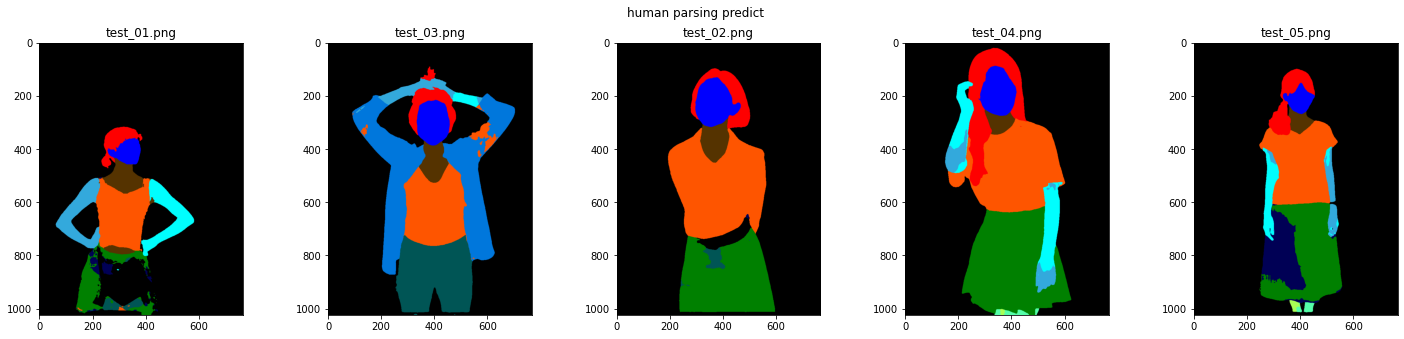

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def show_imgs(imgs, horizon=True, h=25, w=5):
    plt.figure(figsize=(h, w), dpi=72)
    plt.suptitle("human parsing predict")
    for i, img in enumerate(imgs):
        if horizon:
            sub_plt = plt.subplot(1, len(imgs), i+1)
        else:
            sub_plt = plt.subplot(len(imgs), 1, i+1)
        _, img_name = img.rsplit('/', 1)
        img = Image.open(img)
        sub_plt.imshow(img)
        sub_plt.set_title(img_name)

img_root_dir = Path('./output/res/')
imgs = [ str(i) for i in img_root_dir.glob('./*.png')]
imgs

show_imgs(imgs)

In [ ]:
from pathlib import Path
mydata_dir = Path('../mydatasets/')
human_parsings = [str(i) for i in mydata_dir.glob('test/image-parse/*.png')]
show_imgs(human_parsings)

In [25]:
#!cp -r ./output/res/*.png ../mydatasets/test/image-parse/